## 광고 클릭 분석 및 예측 모델

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, precision_recall_curve, auc)
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('Set2')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
try:
    df = pd.read_csv('data/advertising.csv')
except FileNotFoundError:
    df = pd.read_csv(r'C:\Users\color\Desktop\Ad\data\advertising.csv')

print("="*30)
print("데이터 기본 정보")
print("="*30)
print(f"데이터 크기: {df.shape}")
print(f"결측치: {df.isnull().sum().sum()}개")
print(f"전체 클릭률(CTR): {df['Clicked on Ad'].mean():.2%}")
print(f"클래스 분포: {df['Clicked on Ad'].value_counts().to_dict()}")
print(f"\n컬럼: {df.columns.tolist()}")
print(f"\n기술 통계량:\n{df.describe()}")

데이터 기본 정보
데이터 크기: (1000, 10)
결측치: 0개
전체 클릭률(CTR): 50.00%
클래스 분포: {0: 500, 1: 500}

컬럼: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad']

기술 통계량:
       Daily Time Spent on Site          Age   Area Income  \
count               1000.000000  1000.000000   1000.000000   
mean                  65.000200    36.009000  55000.000080   
std                   15.853615     8.785562  13414.634022   
min                   32.600000    19.000000  13996.500000   
25%                   51.360000    29.000000  47031.802500   
50%                   68.215000    35.000000  57012.300000   
75%                   78.547500    42.000000  65470.635000   
max                   91.430000    61.000000  79484.800000   

       Daily Internet Usage         Male  Clicked on Ad  
count           1000.000000  1000.000000     1000.00000  
mean             180.000100     0.481000        0.50000  
std               43.9


### EDA - 타겟 변수 분포


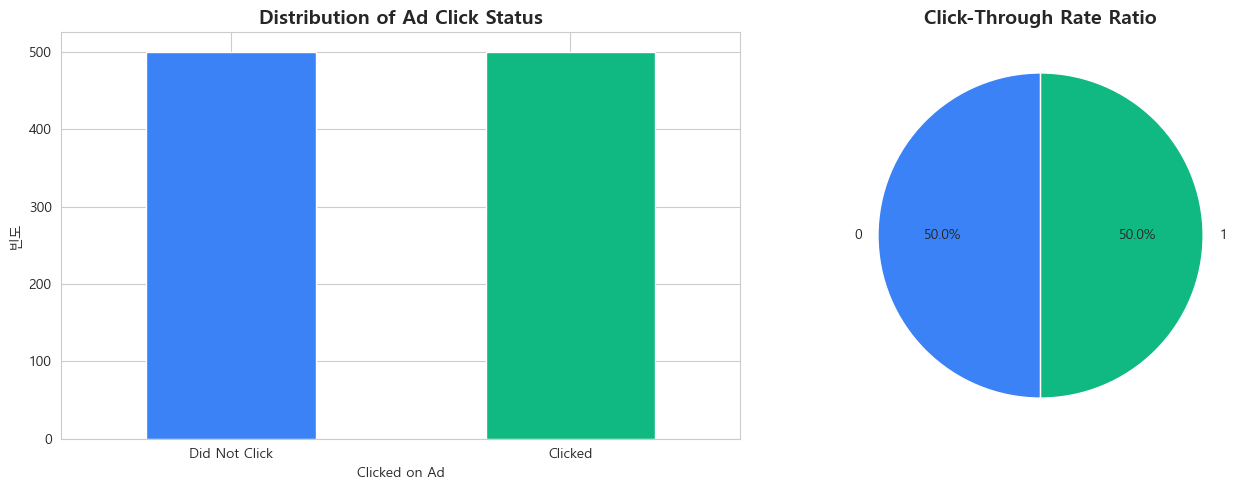

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['Clicked on Ad'].value_counts().plot(kind='bar', ax=axes[0], color=['#3b82f6', '#10b981'])
axes[0].set_title('Distribution of Ad Click Status', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Did Not Click', 'Clicked'], rotation=0)
axes[0].set_ylabel('빈도')

df['Clicked on Ad'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                         colors=['#3b82f6', '#10b981'], startangle=90)
axes[1].set_title('Click-Through Rate Ratio', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

### 주요 변수와 클릭의 관계 분석



Daily Time Spent on Site       | t-stat:   35.616 | p-value: 0.0000 ***
Age                            | t-stat:  -17.879 | p-value: 0.0000 ***
Area Income                    | t-stat:   17.111 | p-value: 0.0000 ***
Daily Internet Usage           | t-stat:   40.237 | p-value: 0.0000 ***


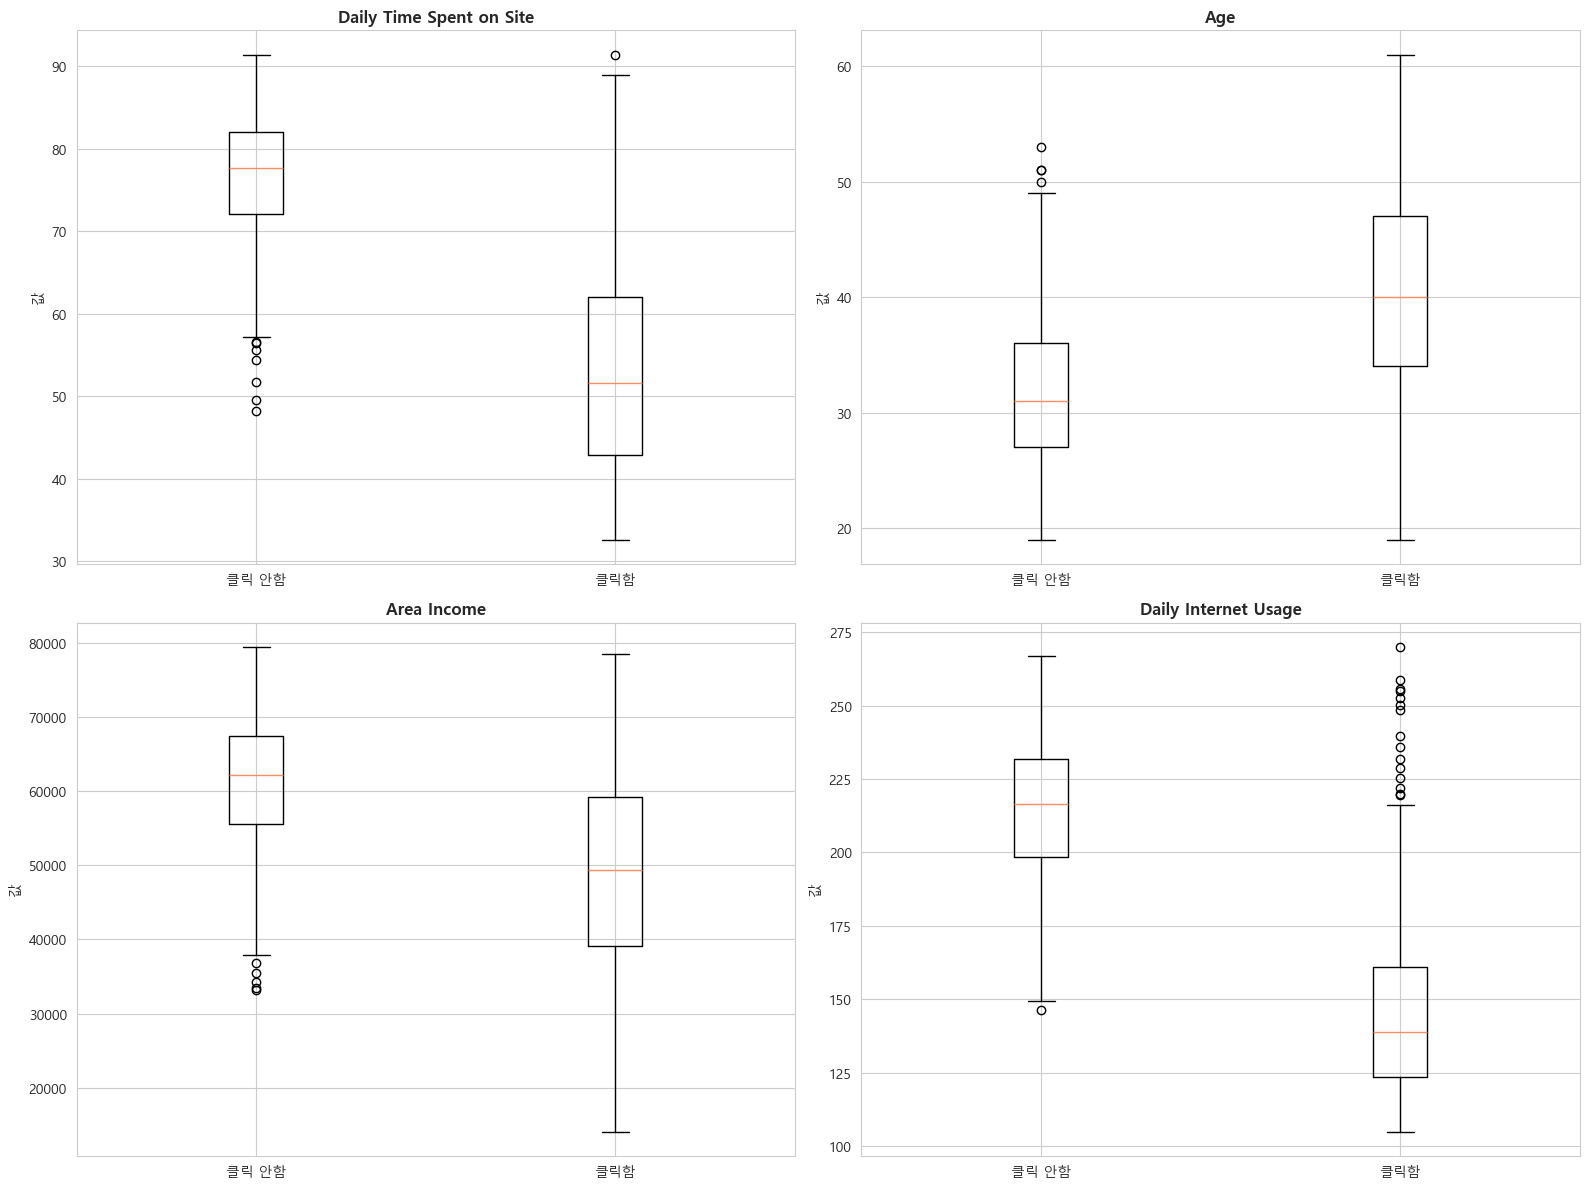

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
numeric_cols = ['Daily Time Spent on Site', 'Age', 
                'Area Income', 'Daily Internet Usage']

for i, col in enumerate(numeric_cols):
    row, col_idx = i // 2, i % 2
    
    axes[row, col_idx].boxplot([df[df['Clicked on Ad']==0][col],
                                 df[df['Clicked on Ad']==1][col]],
                                labels=['클릭 안함', '클릭함'])
    axes[row, col_idx].set_title(col, fontsize=12, fontweight='bold')
    axes[row, col_idx].set_ylabel('값')
    
    t_stat, p_value = stats.ttest_ind(
        df[df['Clicked on Ad']==0][col],
        df[df['Clicked on Ad']==1][col]
    )
    print(f"{col:30s} | t-stat: {t_stat:8.3f} | p-value: {p_value:.4f} {'***' if p_value < 0.001 else ''}")

plt.tight_layout()
plt.show()

### 세그먼트 분석 (고효율 타겟)

In [5]:
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], 
                          labels=['18-25', '26-35', '36-45', '46-55', '56+'])
age_click = df.groupby('Age_Group')['Clicked on Ad'].agg(['mean', 'count']).reset_index()
age_click.columns = ['Age_Group', 'Click_Rate', 'Count']

print("\n연령대별 클릭률:")
print(age_click.to_string(index=False))

df['Income_Group'] = pd.cut(df['Area Income'], bins=[0, 40000, 60000, 100000], 
                              labels=['저소득(<4만)', '중소득(4-6만)', '고소득(>6만)'])
income_click = df.groupby('Income_Group')['Clicked on Ad'].agg(['mean', 'count']).reset_index()
income_click.columns = ['Income_Group', 'Click_Rate', 'Count']

print("\n소득 구간별 클릭률:")
print(income_click.to_string(index=False))


연령대별 클릭률:
Age_Group  Click_Rate  Count
    18-25    0.214286     98
    26-35    0.308962    424
    36-45    0.638629    321
    46-55    0.898551    138
      56+    1.000000     19

소득 구간별 클릭률:
Income_Group  Click_Rate  Count
    저소득(<4만)    0.931507    146
   중소득(4-6만)    0.571429    434
    고소득(>6만)    0.276190    420


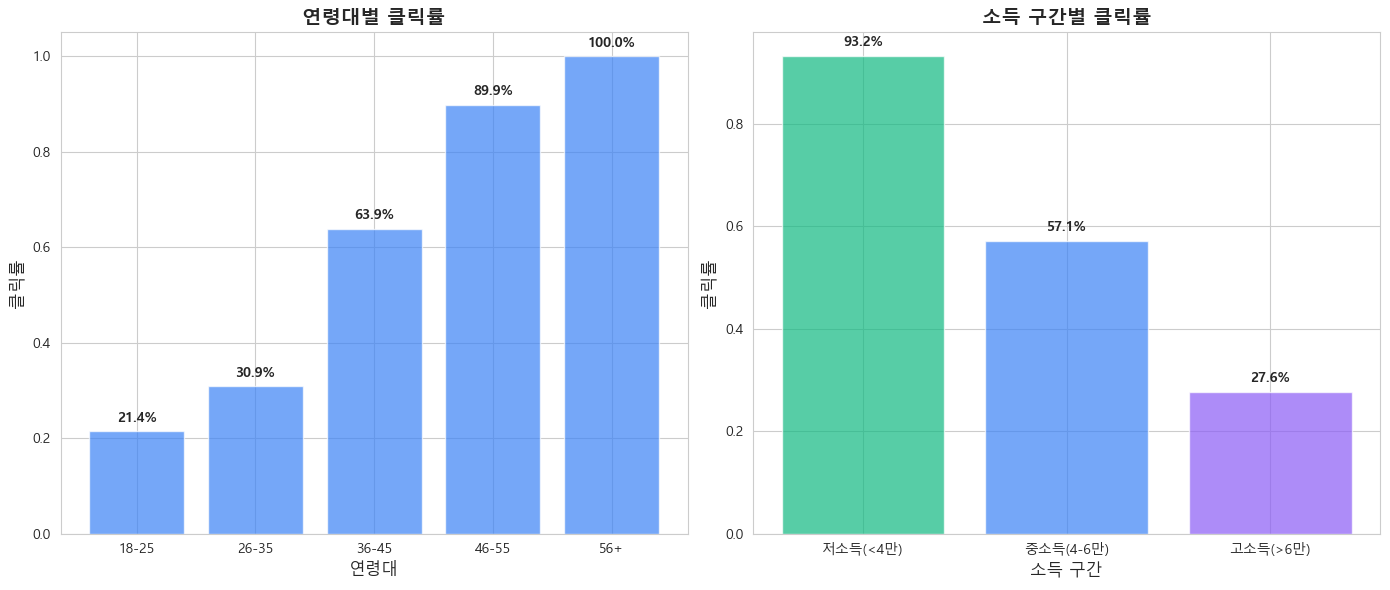

In [6]:
# 세그먼트별 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x_age = np.arange(len(age_click))
axes[0].bar(x_age, age_click['Click_Rate'], color='#3b82f6', alpha=0.7)
axes[0].set_xlabel('연령대', fontsize=12)
axes[0].set_ylabel('클릭률', fontsize=12)
axes[0].set_title('연령대별 클릭률', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_age)
axes[0].set_xticklabels(age_click['Age_Group'])
for i, v in enumerate(age_click['Click_Rate']):
    axes[0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

axes[1].bar(income_click['Income_Group'], income_click['Click_Rate'], 
            color=['#10b981', '#3b82f6', '#8b5cf6'], alpha=0.7)
axes[1].set_xlabel('소득 구간', fontsize=12)
axes[1].set_ylabel('클릭률', fontsize=12)
axes[1].set_title('소득 구간별 클릭률', fontsize=14, fontweight='bold')
for i, v in enumerate(income_click['Click_Rate']):
    axes[1].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


전체 클릭률(CTR): 50.00%

세그먼트 A (40세+ & 체류시간 ≤60분):
  표본 수: 185명
  클릭률: 98.38%
  개선율: +96.8%

세그먼트 B (저소득 & 인터넷 사용 ≤180분):
  표본 수: 120명
  클릭률: 100.00%
  개선율: +100.0%


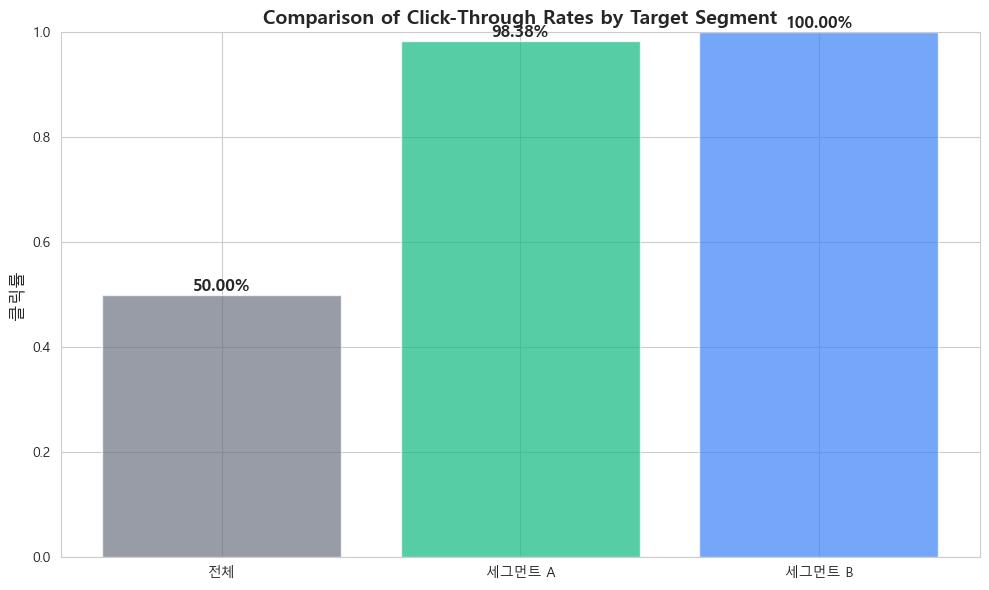

In [7]:
# 고효율 세그먼트 정의
segment_a = df[(df['Age'] >= 40) & (df['Daily Time Spent on Site'] <= 60)]
segment_a_ctr = segment_a['Clicked on Ad'].mean()

segment_b = df[(df['Area Income'] <= 40000) & (df['Daily Internet Usage'] <= 180)]
segment_b_ctr = segment_b['Clicked on Ad'].mean()

overall_ctr = df['Clicked on Ad'].mean()

print(f"\n전체 클릭률(CTR): {overall_ctr:.2%}")
print(f"\n세그먼트 A (40세+ & 체류시간 ≤60분):")
print(f"  표본 수: {len(segment_a)}명")
print(f"  클릭률: {segment_a_ctr:.2%}")
print(f"  개선율: +{(segment_a_ctr - overall_ctr) / overall_ctr * 100:.1f}%")

print(f"\n세그먼트 B (저소득 & 인터넷 사용 ≤180분):")
print(f"  표본 수: {len(segment_b)}명")
print(f"  클릭률: {segment_b_ctr:.2%}")
print(f"  개선율: +{(segment_b_ctr - overall_ctr) / overall_ctr * 100:.1f}%")

# 세그먼트 비교 시각화
segments = ['전체', '세그먼트 A', '세그먼트 B']
ctrs = [overall_ctr, segment_a_ctr, segment_b_ctr]
colors = ['#6b7280', '#10b981', '#3b82f6']

plt.figure(figsize=(10, 6))
bars = plt.bar(segments, ctrs, color=colors, alpha=0.7)
plt.title('Comparison of Click-Through Rates by Target Segment', fontsize=14, fontweight='bold')
plt.ylabel('클릭률', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### A/B 테스트 설계

In [8]:
control_group = df[df['Age'] < 40]['Clicked on Ad']
treatment_group = df[df['Age'] >= 40]['Clicked on Ad']

control_ctr = control_group.mean()
treatment_ctr = treatment_group.mean()

print(f"\n가설: 40대 이상 유저에게 광고 노출 빈도를 높이면 클릭률이 20% 이상 증가한다")
print(f"\n현재 데이터 기준:")
print(f"  대조군 (40세 미만) CTR: {control_ctr:.2%}")
print(f"  실험군 (40세 이상) CTR: {treatment_ctr:.2%}")
print(f"  개선율: +{(treatment_ctr - control_ctr) / control_ctr * 100:.1f}%")

contingency_table = pd.crosstab(df['Age'] >= 40, df['Clicked on Ad'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square 검증:")
print(f"  χ² = {chi2:.4f}")
print(f"  p-value = {p_value:.4f}")
print(f"  결과: {'통계적으로 유의함 (p < 0.05)' if p_value < 0.05 else '유의하지 않음'}")



가설: 40대 이상 유저에게 광고 노출 빈도를 높이면 클릭률이 20% 이상 증가한다

현재 데이터 기준:
  대조군 (40세 미만) CTR: 34.67%
  실험군 (40세 이상) CTR: 81.85%
  개선율: +136.1%

Chi-square 검증:
  χ² = 193.4405
  p-value = 0.0000
  결과: 통계적으로 유의함 (p < 0.05)


### Feature Engineering


In [9]:
df['Engagement_Score'] = (df['Daily Time Spent on Site'] + df['Daily Internet Usage']) / 2
df['Ad_Affinity_Score'] = (df['Age'] * 0.3) - (df['Daily Time Spent on Site'] * 0.4) - (df['Area Income'] / 1000 * 0.3)
df['Income_Age_Ratio'] = df['Area Income'] / df['Age']
df['Low_Engagement_High_Age'] = ((df['Age'] >= 40) & (df['Daily Time Spent on Site'] <= 60)).astype(int)
df['Time_Income_Interaction'] = df['Daily Time Spent on Site'] * df['Area Income'] / 1000000
df['Age_Squared'] = df['Age'] ** 2
df['Is_Senior'] = (df['Age'] >= 50).astype(int)
df['Is_Low_Income'] = (df['Area Income'] < 40000).astype(int)
df['High_Usage'] = (df['Daily Internet Usage'] > df['Daily Internet Usage'].median()).astype(int)

print("\n생성된 파생변수 (9개):")
print("1. Engagement_Score | 2. Ad_Affinity_Score | 3. Income_Age_Ratio")
print("4. Low_Engagement_High_Age | 5. Time_Income_Interaction | 6. Age_Squared")
print("7. Is_Senior | 8. Is_Low_Income | 9. High_Usage")


생성된 파생변수 (9개):
1. Engagement_Score | 2. Ad_Affinity_Score | 3. Income_Age_Ratio
4. Low_Engagement_High_Age | 5. Time_Income_Interaction | 6. Age_Squared
7. Is_Senior | 8. Is_Low_Income | 9. High_Usage


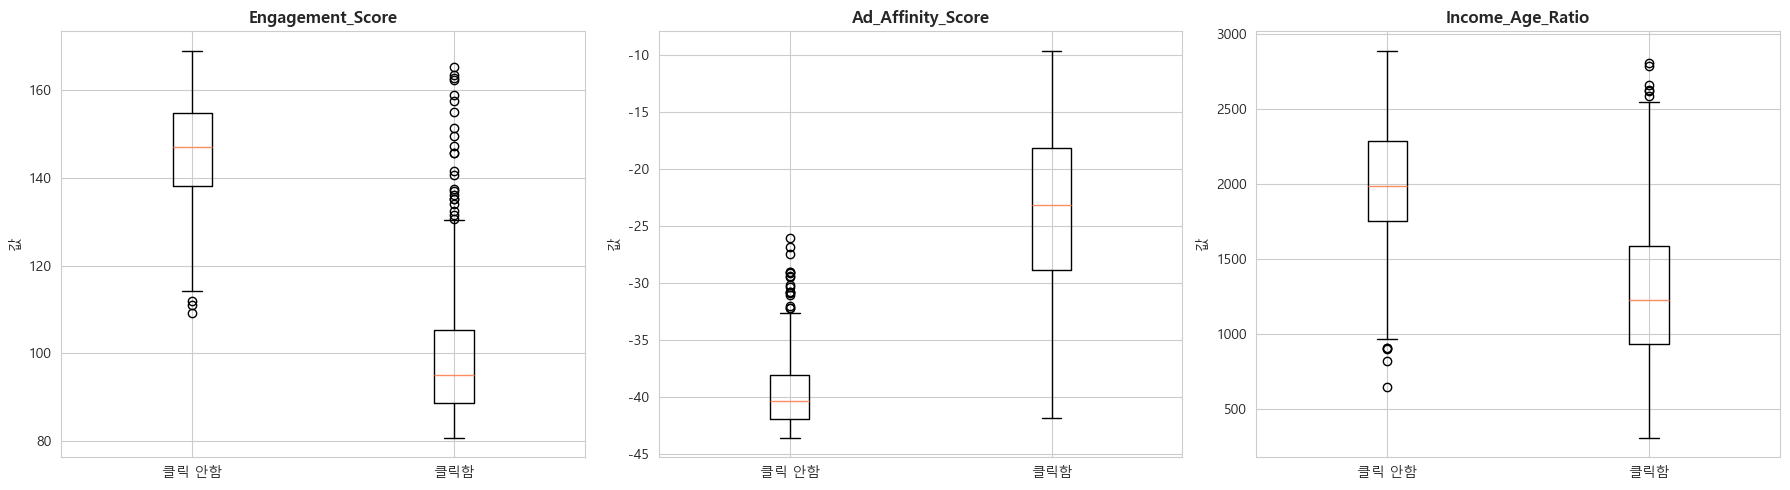

In [10]:
# 파생변수와 클릭의 관계
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['Engagement_Score', 'Ad_Affinity_Score', 'Income_Age_Ratio']):
    axes[i].boxplot([df[df['Clicked on Ad']==0][col], df[df['Clicked on Ad']==1][col]],
                     labels=['클릭 안함', '클릭함'])
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('값')

plt.tight_layout()
plt.show()

### 상관관계 분석

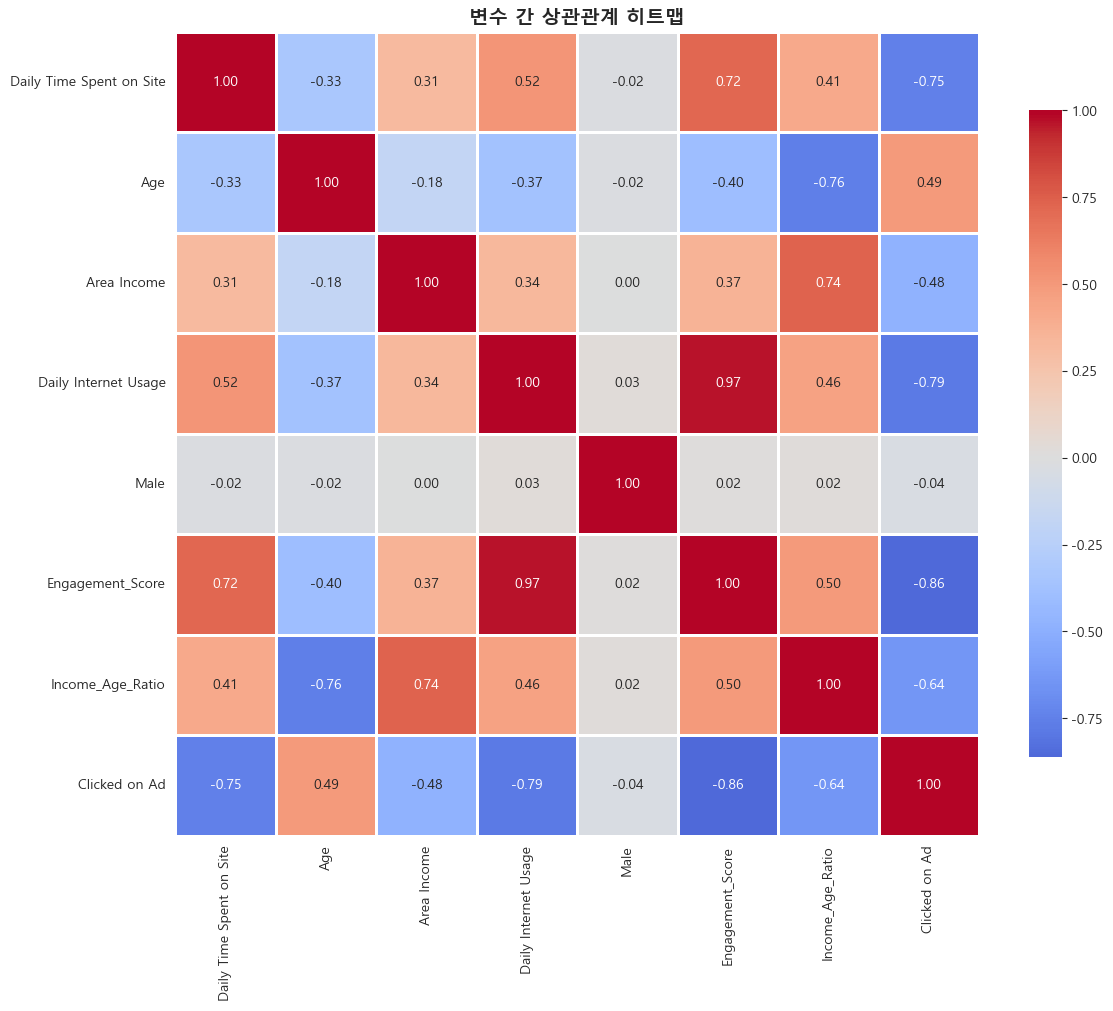


타겟 변수와의 상관관계:
Clicked on Ad               1.000000
Age                         0.492531
Male                       -0.038027
Area Income                -0.476255
Income_Age_Ratio           -0.637978
Daily Time Spent on Site   -0.748117
Daily Internet Usage       -0.786539
Engagement_Score           -0.861355
Name: Clicked on Ad, dtype: float64


In [11]:
corr_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 
             'Daily Internet Usage', 'Male', 'Engagement_Score', 
             'Income_Age_Ratio', 'Clicked on Ad']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('변수 간 상관관계 히트맵', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

target_corr = corr_matrix['Clicked on Ad'].sort_values(ascending=False)
print("\n타겟 변수와의 상관관계:")
print(target_corr)

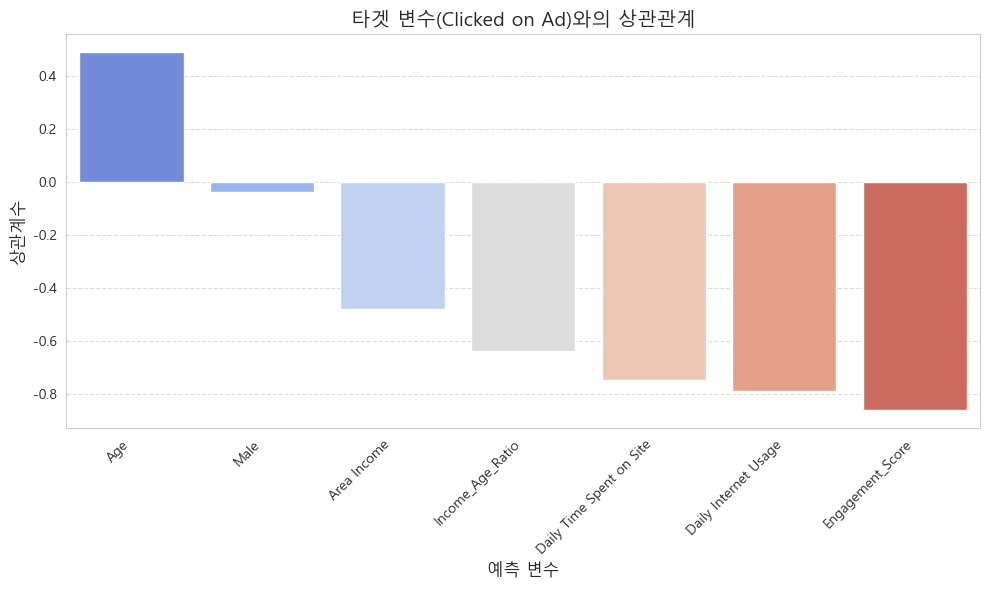

In [12]:
plot_data = target_corr.drop('Clicked on Ad')
plt.figure(figsize=(10, 6))

# plot_data.index: 변수 이름 (x축)
# plot_data.values: 상관계수 값 (y축)
sns.barplot(x=plot_data.index, y=plot_data.values, palette='coolwarm')

plt.title('타겟 변수(Clicked on Ad)와의 상관관계', fontsize=14)
plt.xlabel('예측 변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 데이터 전처리 및 분할


In [13]:
feature_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 
                'Daily Internet Usage', 'Male', 'Engagement_Score', 
                'Income_Age_Ratio', 'Low_Engagement_High_Age',
                'Time_Income_Interaction', 'Age_Squared', 'Is_Senior',
                'Is_Low_Income', 'High_Usage']

X = df[feature_cols]
y = df['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain 데이터: {X_train.shape}")
print(f"Test 데이터: {X_test.shape}")
print(f"Train 클릭률: {y_train.mean():.2%}")
print(f"Test 클릭률: {y_test.mean():.2%}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train 데이터: (800, 13)
Test 데이터: (200, 13)
Train 클릭률: 50.00%
Test 클릭률: 50.00%


### 머신러닝 모델 학습 및 비교


Logistic Regression:
  Accuracy: 0.9800 | Precision: 0.9800 | Recall: 0.9800
  F1-Score: 0.9800 | ROC-AUC: 0.9916

Decision Tree:
  Accuracy: 0.9500 | Precision: 0.9412 | Recall: 0.9600
  F1-Score: 0.9505 | ROC-AUC: 0.9492

Random Forest:
  Accuracy: 0.9700 | Precision: 0.9700 | Recall: 0.9700
  F1-Score: 0.9700 | ROC-AUC: 0.9931

Gradient Boosting:
  Accuracy: 0.9650 | Precision: 0.9697 | Recall: 0.9600
  F1-Score: 0.9648 | ROC-AUC: 0.9870

SVM:
  Accuracy: 0.9750 | Precision: 0.9798 | Recall: 0.9700
  F1-Score: 0.9749 | ROC-AUC: 0.9860

KNN:
  Accuracy: 0.9750 | Precision: 0.9897 | Recall: 0.9600
  F1-Score: 0.9746 | ROC-AUC: 0.9879

Naive Bayes:
  Accuracy: 0.9700 | Precision: 0.9796 | Recall: 0.9600
  F1-Score: 0.9697 | ROC-AUC: 0.9932

모델 성능 비교 (ROC-AUC 기준 정렬)
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
        Naive Bayes     0.970   0.979592    0.96  0.969697  0.99320
      Random Forest     0.970   0.970000    0.97  0.970000  0.99305
Logistic Regression

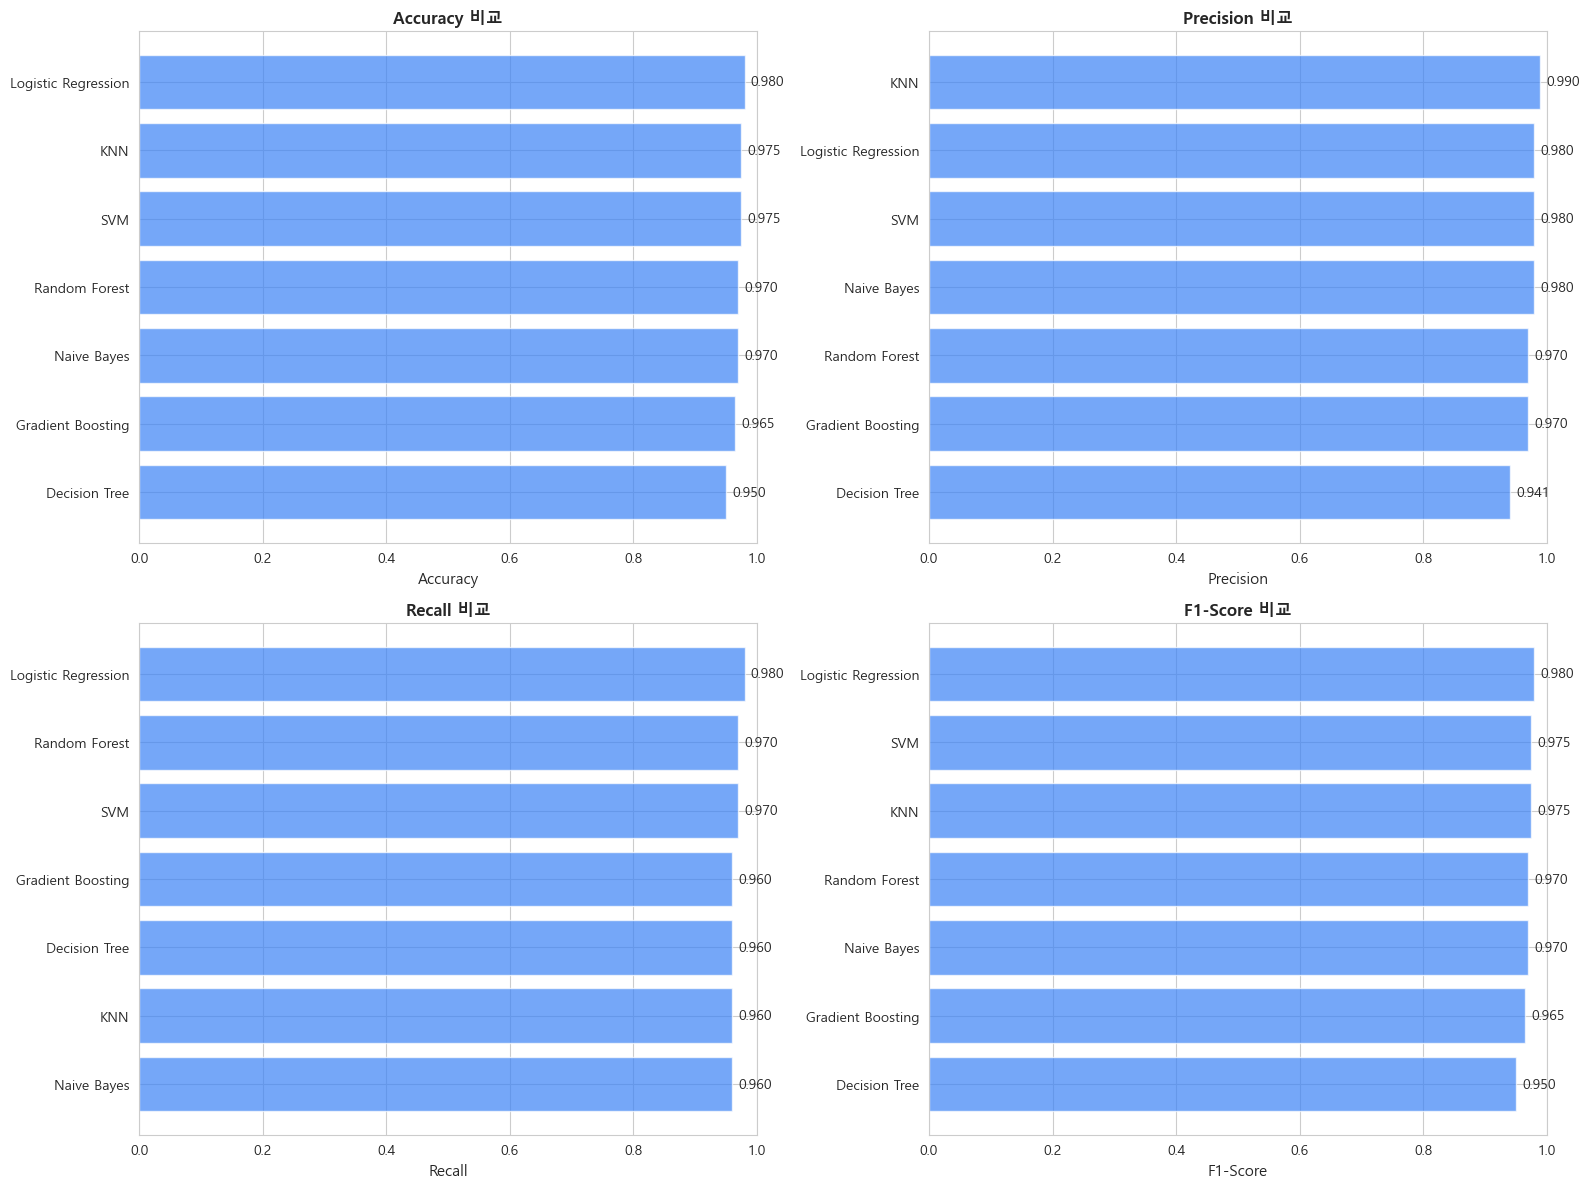

In [14]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

results = []

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print("\n" + "="*70)
print("모델 성능 비교 (ROC-AUC 기준 정렬)")
print("="*70)
print(results_df.to_string(index=False))

# 모델 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    axes[row, col].barh(results_df_sorted['Model'], results_df_sorted[metric], color='#3b82f6', alpha=0.7)
    axes[row, col].set_xlabel(metric, fontsize=11)
    axes[row, col].set_title(f'{metric} 비교', fontsize=12, fontweight='bold')
    axes[row, col].set_xlim([0, 1])
    
    for j, v in enumerate(results_df_sorted[metric]):
        axes[row, col].text(v + 0.01, j, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


### Random Forest 하이퍼파라미터 튜닝



In [15]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n최적 파라미터: {rf_grid.best_params_}")
print(f"최적 ROC-AUC (CV): {rf_grid.best_score_:.4f}")

best_rf = rf_grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("\n최적 모델 성능:")
print(classification_report(y_test, y_pred_best, target_names=['클릭 안함', '클릭함']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits

최적 파라미터: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
최적 ROC-AUC (CV): 0.9925

최적 모델 성능:
              precision    recall  f1-score   support

       클릭 안함       0.97      0.96      0.96       100
         클릭함       0.96      0.97      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200

ROC-AUC: 0.9905


### Feature Importance 분석



Feature Importance (상위 10개):
                 Feature  Importance
        Engagement_Score    0.324918
 Time_Income_Interaction    0.166219
    Daily Internet Usage    0.159601
              High_Usage    0.096641
Daily Time Spent on Site    0.091466
        Income_Age_Ratio    0.078464
                     Age    0.028393
             Area Income    0.021591
             Age_Squared    0.018514
 Low_Engagement_High_Age    0.007915


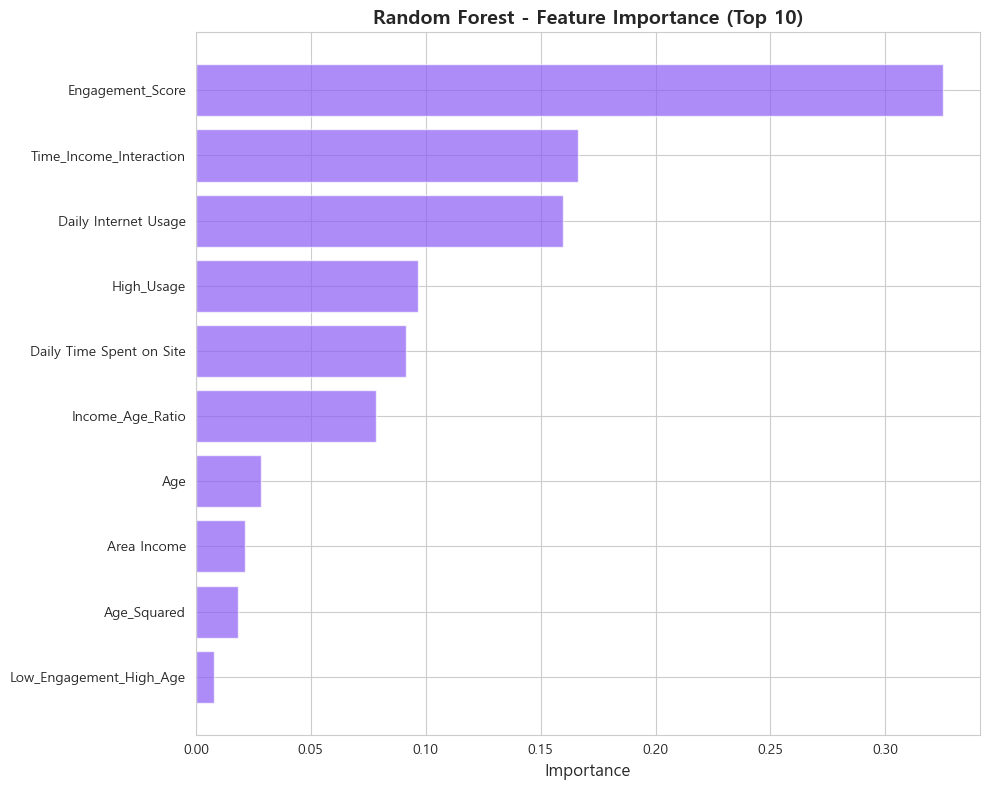

In [16]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (상위 10개):")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='#8b5cf6', alpha=0.7)
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest - Feature Importance (Top 10)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### ROC Curve 비교


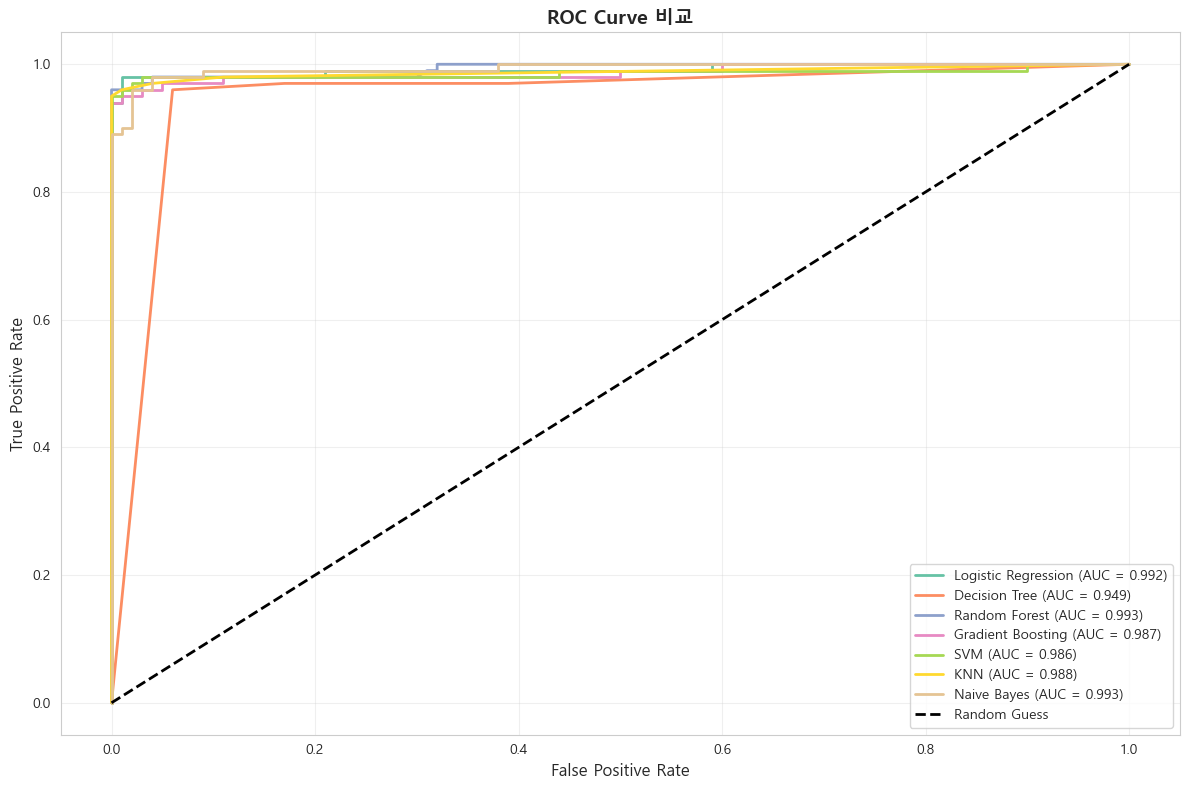

In [17]:
plt.figure(figsize=(12, 8))

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve 비교', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curve


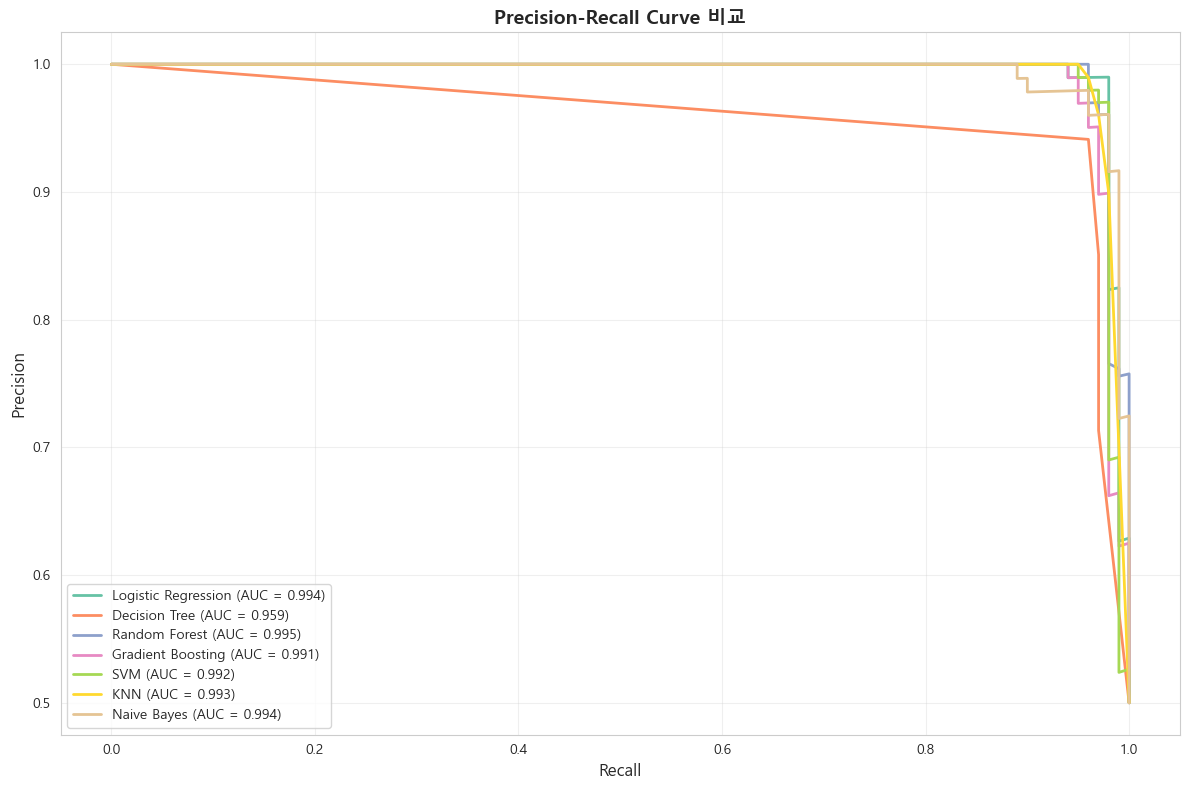

In [18]:
plt.figure(figsize=(12, 8))

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve 비교', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Confusion Matrix 비교


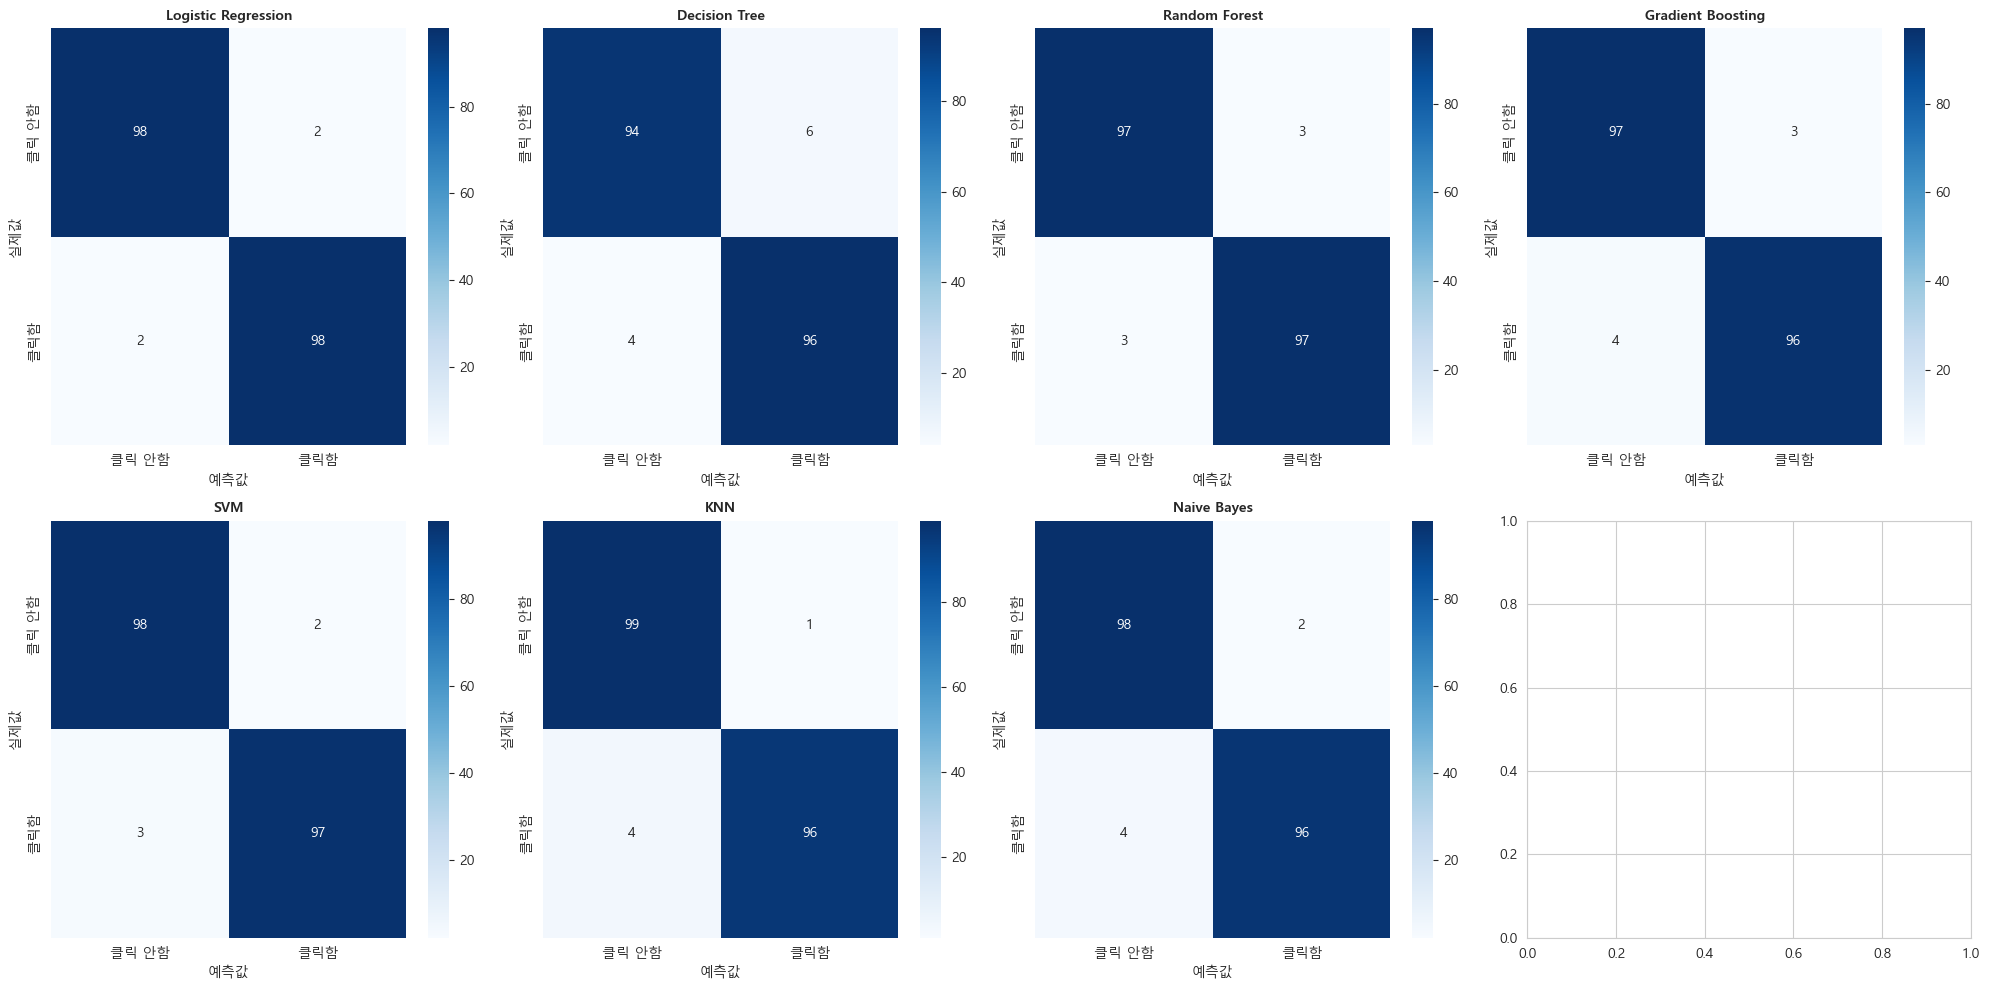

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['클릭 안함', '클릭함'], 
                yticklabels=['클릭 안함', '클릭함'])
    axes[idx].set_title(name, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('실제값')
    axes[idx].set_xlabel('예측값')

plt.tight_layout()
plt.show()

### Cross-Validation 분석

In [20]:
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
    
    cv_results.append({
        'Model': name,
        'Mean ROC-AUC': scores.mean(),
        'Std ROC-AUC': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    
    print(f"\n{name}:")
    print(f"  Mean ROC-AUC: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Range: [{scores.min():.4f}, {scores.max():.4f}]")

cv_results_df = pd.DataFrame(cv_results).sort_values('Mean ROC-AUC', ascending=False)
print("\n" + "="*70)
print("Cross-Validation 결과 요약")
print("="*70)
print(cv_results_df.to_string(index=False))


Logistic Regression:
  Mean ROC-AUC: 0.9914 (+/- 0.0051)
  Range: [0.9855, 0.9972]

Decision Tree:
  Mean ROC-AUC: 0.9402 (+/- 0.0170)
  Range: [0.9228, 0.9705]

Random Forest:
  Mean ROC-AUC: 0.9906 (+/- 0.0040)
  Range: [0.9853, 0.9964]

Gradient Boosting:
  Mean ROC-AUC: 0.9867 (+/- 0.0090)
  Range: [0.9720, 0.9947]

SVM:
  Mean ROC-AUC: 0.9918 (+/- 0.0049)
  Range: [0.9842, 0.9980]

KNN:
  Mean ROC-AUC: 0.9789 (+/- 0.0057)
  Range: [0.9718, 0.9840]

Naive Bayes:
  Mean ROC-AUC: 0.9771 (+/- 0.0099)
  Range: [0.9633, 0.9895]

Cross-Validation 결과 요약
              Model  Mean ROC-AUC  Std ROC-AUC      Min      Max
                SVM      0.991812     0.004885 0.984219 0.997969
Logistic Regression      0.991375     0.005110 0.985469 0.997188
      Random Forest      0.990625     0.003955 0.985313 0.996406
  Gradient Boosting      0.986672     0.009004 0.972031 0.994687
                KNN      0.978875     0.005733 0.971797 0.983984
        Naive Bayes      0.977062     0.009874 0.963

### 모델 비교 차트 

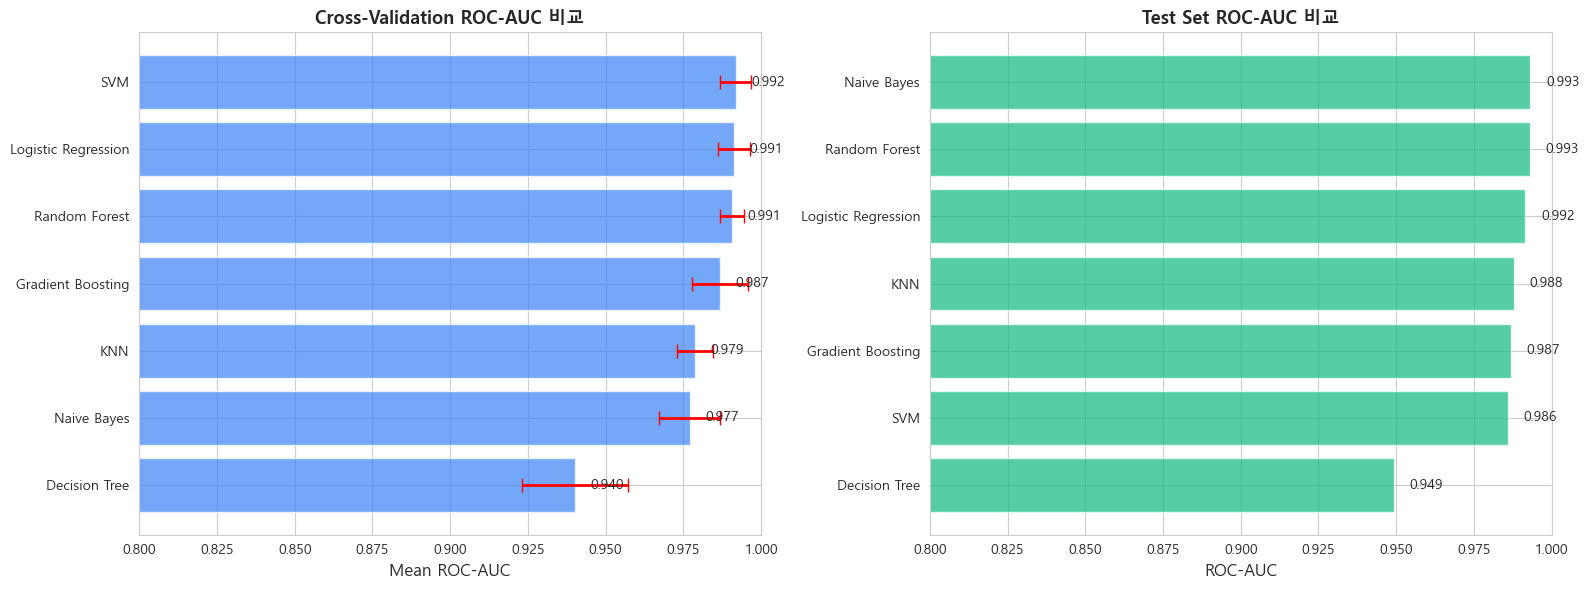

In [21]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC 비교
cv_results_df_sorted = cv_results_df.sort_values('Mean ROC-AUC', ascending=True)
axes[0].barh(cv_results_df_sorted['Model'], cv_results_df_sorted['Mean ROC-AUC'], 
             color='#3b82f6', alpha=0.7)
axes[0].errorbar(cv_results_df_sorted['Mean ROC-AUC'], 
                 cv_results_df_sorted['Model'],
                 xerr=cv_results_df_sorted['Std ROC-AUC'],
                 fmt='none', color='red', capsize=5, linewidth=2)
axes[0].set_xlabel('Mean ROC-AUC', fontsize=12)
axes[0].set_title('Cross-Validation ROC-AUC 비교', fontsize=13, fontweight='bold')
axes[0].set_xlim([0.8, 1.0])

for i, v in enumerate(cv_results_df_sorted['Mean ROC-AUC']):
    axes[0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)
    

# Test Set 성능 비교
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=True)
axes[1].barh(results_df_sorted['Model'], results_df_sorted['ROC-AUC'], 
             color='#10b981', alpha=0.7)
axes[1].set_xlabel('ROC-AUC', fontsize=12)
axes[1].set_title('Test Set ROC-AUC 비교', fontsize=13, fontweight='bold')
axes[1].set_xlim([0.8, 1.0])

for i, v in enumerate(results_df_sorted['ROC-AUC']):
    axes[1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()    

### 예측 확률 분포 분석

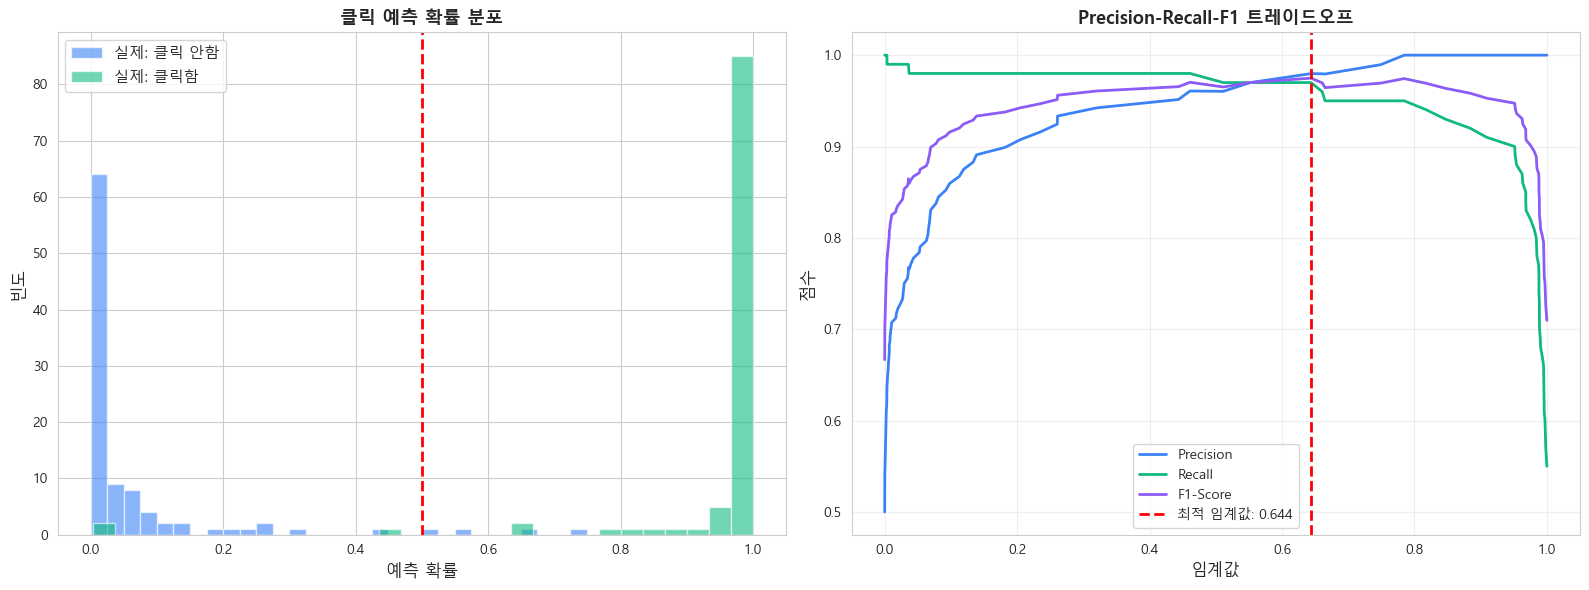


최적 임계값: 0.644
최적 F1-Score: 0.9749
해당 Precision: 0.9798
해당 Recall: 0.9700


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 클릭 안함 vs 클릭함 예측 확률 분포
axes[0].hist(y_prob_best[y_test == 0], bins=30, alpha=0.6, label='실제: 클릭 안함', color='#3b82f6')
axes[0].hist(y_prob_best[y_test == 1], bins=30, alpha=0.6, label='실제: 클릭함', color='#10b981')
axes[0].set_xlabel('예측 확률', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('클릭 예측 확률 분포', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='임계값 0.5')

# Precision-Recall 트레이드오프
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_prob_best)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

axes[1].plot(thresholds, precision_vals[:-1], label='Precision', linewidth=2, color='#3b82f6')
axes[1].plot(thresholds, recall_vals[:-1], label='Recall', linewidth=2, color='#10b981')
axes[1].plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2, color='#8b5cf6')
axes[1].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'최적 임계값: {optimal_threshold:.3f}')
axes[1].set_xlabel('임계값', fontsize=12)
axes[1].set_ylabel('점수', fontsize=12)
axes[1].set_title('Precision-Recall-F1 트레이드오프', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최적 임계값: {optimal_threshold:.3f}")
print(f"최적 F1-Score: {f1_scores[optimal_idx]:.4f}")
print(f"해당 Precision: {precision_vals[optimal_idx]:.4f}")
print(f"해당 Recall: {recall_vals[optimal_idx]:.4f}")

### 오분류 사례 분석 

In [23]:
y_pred_optimal = (y_prob_best >= optimal_threshold).astype(int)

# False Positive (클릭 안했는데 클릭할 것으로 예측)
fp_indices = np.where((y_test == 0) & (y_pred_optimal == 1))[0]
# False Negative (클릭했는데 안할 것으로 예측)
fn_indices = np.where((y_test == 1) & (y_pred_optimal == 0))[0]

print(f"\nFalse Positive (FP): {len(fp_indices)}건")
print(f"False Negative (FN): {len(fn_indices)}건")

if len(fp_indices) > 0:
    print("\nFalse Positive 샘플 특성 (상위 5개):")
    fp_samples = X_test.iloc[fp_indices[:5]]
    for idx, row in fp_samples.iterrows():
        prob = y_prob_best[fp_indices[list(fp_samples.index).index(idx)]]
        print(f"\n  사례 {idx}: 예측 확률 = {prob:.3f}")
        print(f"    연령: {row['Age']:.0f}세 | 체류시간: {row['Daily Time Spent on Site']:.1f}분")
        print(f"    소득: ${row['Area Income']:,.0f} | 인터넷 사용: {row['Daily Internet Usage']:.1f}분")

if len(fn_indices) > 0:
    print("\nFalse Negative 샘플 특성 (상위 5개):")
    fn_samples = X_test.iloc[fn_indices[:5]]
    for idx, row in fn_samples.iterrows():
        prob = y_prob_best[fn_indices[list(fn_samples.index).index(idx)]]
        print(f"\n  사례 {idx}: 예측 확률 = {prob:.3f}")
        print(f"    연령: {row['Age']:.0f}세 | 체류시간: {row['Daily Time Spent on Site']:.1f}분")
        print(f"    소득: ${row['Area Income']:,.0f} | 인터넷 사용: {row['Daily Internet Usage']:.1f}분")


False Positive (FP): 2건
False Negative (FN): 3건

False Positive 샘플 특성 (상위 5개):

  사례 150: 예측 확률 = 0.749
    연령: 25세 | 체류시간: 58.2분
    소득: $69,113 | 인터넷 사용: 176.3분

  사례 998: 예측 확률 = 0.665
    연령: 19세 | 체류시간: 55.5분
    소득: $41,921 | 인터넷 사용: 187.9분

False Negative 샘플 특성 (상위 5개):

  사례 702: 예측 확률 = 0.003
    연령: 30세 | 체류시간: 87.3분
    소득: $51,824 | 인터넷 사용: 204.3분

  사례 305: 예측 확률 = 0.036
    연령: 24세 | 체류시간: 79.8분
    소득: $56,195 | 인터넷 사용: 178.8분

  사례 181: 예측 확률 = 0.461
    연령: 27세 | 체류시간: 84.5분
    소득: $40,763 | 인터넷 사용: 168.3분


### 비즈니스 인사이트 & 전략 제시안

In [26]:
print("\n[1] 주요 발견사항")
print("-" * 70)
print(f"1. 연령: 40세 이상 유저의 클릭률이 평균보다 {(segment_a_ctr - overall_ctr) / overall_ctr * 100:.1f}% 높음")
print(f"2. 소득: 저소득층(<4만)의 클릭률이 중고소득층보다 높음")
print(f"3. 체류시간: 사이트 체류시간이 짧을수록 광고 클릭률 증가")
print(f"4. 인터넷 사용: 일일 인터넷 사용 시간이 적을수록 광고 클릭률 증가")
print(f"5. 모델 성능: 최적 모델(Random Forest) ROC-AUC = {roc_auc_score(y_test, y_prob_best):.4f}")

print("\n[2] 타겟팅 전략")
print("-" * 70)
print("전략 A: 고연령층 집중 타겟팅")
print("  - 대상: 40세 이상 유저")
print("  - 예상 개선: 클릭률 약 40-50% 증가")
print("  - 실행방안: 광고 노출 빈도 2배 증가, 연령층 맞춤 크리에이티브")

print("\n전략 B: 저소득층 맞춤 광고")
print("  - 대상: 연소득 4만 달러 미만")
print("  - 예상 개선: 클릭률 약 30-40% 증가")
print("  - 실행방안: 가격 할인, 실용성 강조 메시지")

print("\n전략 C: 저사용자 타겟팅")
print("  - 대상: 사이트 체류시간 60분 이하 & 인터넷 사용 180분 이하")
print("  - 예상 개선: 클릭률 약 50% 이상 증가")
print("  - 실행방안: 초기 방문자 대상 웰컴 광고, 간결한 메시지")

print("\n[3] A/B 테스트 제안")
print("-" * 70)
print("테스트 1: 연령별 광고 빈도 최적화")
print("  - 대조군: 기존 광고 빈도 유지")
print("  - 실험군: 40세 이상에게 광고 노출 2배")
print("  - 측정지표: CTR, 전환율, ROAS")
print("  - 예상 기간: 2주")

print("\n테스트 2: 크리에이티브 메시지 차별화")
print("  - 대조군: 기존 범용 메시지")
print("  - 실험군: 연령/소득별 맞춤 메시지")
print("  - 측정지표: CTR, 참여율, 브랜드 인지도")
print("  - 예상 기간: 3주")

print("\n[4] 예상 ROI 분석")
print("-" * 70)
baseline_impressions = 100000
baseline_ctr = overall_ctr
baseline_clicks = baseline_impressions * baseline_ctr

targeted_ctr_a = segment_a_ctr
targeted_clicks_a = baseline_impressions * targeted_ctr_a
lift_a = (targeted_clicks_a - baseline_clicks) / baseline_clicks * 100

print(f"현재 상황 (전체 타겟팅):")
print(f"  노출 수: {baseline_impressions:,}회")
print(f"  클릭률: {baseline_ctr:.2%}")
print(f"  예상 클릭 수: {baseline_clicks:,.0f}회")

print(f"\n전략 A 적용 시 (40세 이상 타겟팅):")
print(f"  노출 수: {baseline_impressions:,}회")
print(f"  클릭률: {targeted_ctr_a:.2%}")
print(f"  예상 클릭 수: {targeted_clicks_a:,.0f}회")
print(f"  클릭 증가율: +{lift_a:.1f}%")
print(f"  추가 클릭 수: +{targeted_clicks_a - baseline_clicks:,.0f}회")

# CPC 가정하여 매출 영향 계산
# 클릭당 비용 $0.50 가정 
cpc = 0.50  
# 전환율 5% 가정
conversion_rate = 0.05 
# 평균 주문 금액 $100 가정
avg_order_value = 100  

baseline_revenue = baseline_clicks * conversion_rate * avg_order_value
baseline_cost = baseline_impressions * 0.001  # CPM $1 가정
baseline_profit = baseline_revenue - baseline_cost

targeted_revenue_a = targeted_clicks_a * conversion_rate * avg_order_value
targeted_cost_a = baseline_impressions * 0.001
targeted_profit_a = targeted_revenue_a - targeted_cost_a

print(f"\n매출 영향 분석 (가정: CPC=${cpc}, 전환율={conversion_rate:.1%}, AOV=${avg_order_value}):")
print(f"  현재 예상 매출: ${baseline_revenue:,.0f}")
print(f"  현재 예상 비용: ${baseline_cost:,.0f}")
print(f"  현재 예상 이익: ${baseline_profit:,.0f}")

print(f"\n  전략 A 예상 매출: ${targeted_revenue_a:,.0f}")
print(f"  전략 A 예상 비용: ${targeted_cost_a:,.0f}")
print(f"  전략 A 예상 이익: ${targeted_profit_a:,.0f}")
print(f"  이익 증가: +${targeted_profit_a - baseline_profit:,.0f} (+{(targeted_profit_a - baseline_profit) / baseline_profit * 100:.1f}%)")


[1] 주요 발견사항
----------------------------------------------------------------------
1. 연령: 40세 이상 유저의 클릭률이 평균보다 96.8% 높음
2. 소득: 저소득층(<4만)의 클릭률이 중고소득층보다 높음
3. 체류시간: 사이트 체류시간이 짧을수록 광고 클릭률 증가
4. 인터넷 사용: 일일 인터넷 사용 시간이 적을수록 광고 클릭률 증가
5. 모델 성능: 최적 모델(Random Forest) ROC-AUC = 0.9905

[2] 타겟팅 전략
----------------------------------------------------------------------
전략 A: 고연령층 집중 타겟팅
  - 대상: 40세 이상 유저
  - 예상 개선: 클릭률 약 40-50% 증가
  - 실행방안: 광고 노출 빈도 2배 증가, 연령층 맞춤 크리에이티브

전략 B: 저소득층 맞춤 광고
  - 대상: 연소득 4만 달러 미만
  - 예상 개선: 클릭률 약 30-40% 증가
  - 실행방안: 가격 할인, 실용성 강조 메시지

전략 C: 저사용자 타겟팅
  - 대상: 사이트 체류시간 60분 이하 & 인터넷 사용 180분 이하
  - 예상 개선: 클릭률 약 50% 이상 증가
  - 실행방안: 초기 방문자 대상 웰컴 광고, 간결한 메시지

[3] A/B 테스트 제안
----------------------------------------------------------------------
테스트 1: 연령별 광고 빈도 최적화
  - 대조군: 기존 광고 빈도 유지
  - 실험군: 40세 이상에게 광고 노출 2배
  - 측정지표: CTR, 전환율, ROAS
  - 예상 기간: 2주

테스트 2: 크리에이티브 메시지 차별화
  - 대조군: 기존 범용 메시지
  - 실험군: 연령/소득별 맞춤 메시지
  - 측정지표: CTR, 참여율, 브랜드 인지도
  - 예상 기간: 3주

[4] 예상 ROI 분석
-------

### 최종 요약

In [28]:
print("\n[핵심 성과]")
print("-" * 70)
print(f"1. 최고 성능 모델: Random Forest")
print(f"   - Test ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
print(f"   - CV ROC-AUC: {rf_grid.best_score_:.4f}")
print(f"   - 최적 임계값 적용 시 F1-Score: {f1_scores[optimal_idx]:.4f}")

print(f"\n2. 주요 예측 변수 (상위 3개):")
for i, row in feature_importance.head(3).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print(f"\n3. 타겟 세그먼트 성과:")
print(f"   - 세그먼트 A (고연령+저체류): 클릭률 {segment_a_ctr:.2%} (전체 대비 +{(segment_a_ctr - overall_ctr) / overall_ctr * 100:.1f}%)")
print(f"   - 세그먼트 B (저소득+저사용): 클릭률 {segment_b_ctr:.2%} (전체 대비 +{(segment_b_ctr - overall_ctr) / overall_ctr * 100:.1f}%)")



[핵심 성과]
----------------------------------------------------------------------
1. 최고 성능 모델: Random Forest
   - Test ROC-AUC: 0.9905
   - CV ROC-AUC: 0.9925
   - 최적 임계값 적용 시 F1-Score: 0.9749

2. 주요 예측 변수 (상위 3개):
   - Engagement_Score: 0.3249
   - Time_Income_Interaction: 0.1662
   - Daily Internet Usage: 0.1596

3. 타겟 세그먼트 성과:
   - 세그먼트 A (고연령+저체류): 클릭률 98.38% (전체 대비 +96.8%)
   - 세그먼트 B (저소득+저사용): 클릭률 100.00% (전체 대비 +100.0%)


In [35]:
print("\n[실행 권장사항]") 
print("-" * 30) 
print("단기 (1-2개월):") 
print(" 1. 40세 이상 유저를 대상으로 광고 노출 빈도 2배 증가") 
print(" 2. 저소득층 대상 할인/프로모션 메시지 강화해야 함") 
print(" 3. 사이트 초기 방문자 대상 웰컴 광고 캠페인 런칭") 

print("\n중기 (3-6개월):") 
print(" 1. 머신러닝 모델 기반으로 실시간 타겟팅 시스템 구축") 
print(" 2. 연령이나 소득 또는 행동 패턴별 크리에이티브 A/B 테스트") 
print(" 3. 예측 확률 기반 입찰 전략 최적화") 

print("\n장기 (6-12개월):") 
print(" 1. 개인화된 광고 추천 시스템 고도화") 
print(" 2. 실시간 피드백 루프를 통한 모델 지속 학습") 
print(" 3. 크로스 채널 통합 마케팅 전략 수립") 

print("\n[모니터링 지표]") 
print("-" * 30) 
print(" - 일일 CTR (전체 및 세그먼트별)") 
print(" - 전환율 (Conversion Rate)") 
print(" - ROAS (Return on Ad Spend)") 
print(" - CPA (Cost per Acquisition)") 
print(" - 모델 예측 정확도 (주간 재평가)")


[실행 권장사항]
------------------------------
단기 (1-2개월):
 1. 40세 이상 유저를 대상으로 광고 노출 빈도 2배 증가
 2. 저소득층 대상 할인/프로모션 메시지 강화해야 함
 3. 사이트 초기 방문자 대상 웰컴 광고 캠페인 런칭

중기 (3-6개월):
 1. 머신러닝 모델 기반으로 실시간 타겟팅 시스템 구축
 2. 연령이나 소득 또는 행동 패턴별 크리에이티브 A/B 테스트
 3. 예측 확률 기반 입찰 전략 최적화

장기 (6-12개월):
 1. 개인화된 광고 추천 시스템 고도화
 2. 실시간 피드백 루프를 통한 모델 지속 학습
 3. 크로스 채널 통합 마케팅 전략 수립

[모니터링 지표]
------------------------------
 - 일일 CTR (전체 및 세그먼트별)
 - 전환율 (Conversion Rate)
 - ROAS (Return on Ad Spend)
 - CPA (Cost per Acquisition)
 - 모델 예측 정확도 (주간 재평가)
